In [1]:
import sys
sys.path.append('/NDDepth/Estimation/nddepth_custom')

In [2]:
import os
import torch
import open3d as o3d
from torchvision import transforms
import json
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch.backends.cudnn as cudnn
from networks.NewCRFDepth import NewCRFDepth
from utils import post_process_depth, flip_lr, compute_errors

CAMERA_INFO = "/scratchdata/processed/indoor_lift/camera_info.json"
IMG = "/scratchdata/processed/indoor_lift/rgb/1000.png"
BAG_FILE = "/sratchdata/indoor_short.bag"
MODEL_PATH = "/scratchdata/nyu.pth"

ENCODER = "large07"
MAX_DEPTH = 10
EPOCH = 5

torch.manual_seed(42)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


/usr/local/lib/python3.10/dist-packages/mmengine/optim/optimizer/zero_optimizer.py:11: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import \


In [3]:
camera_info = json.load(open(CAMERA_INFO))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8606442..2.64].


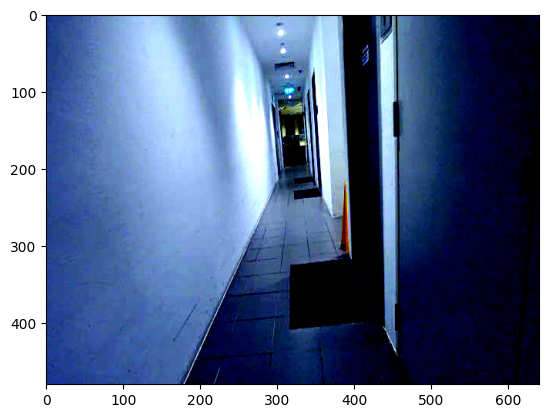

In [4]:
image = Image.open(IMG)
image = image.resize((640, 480), Image.BILINEAR)
image = np.array(image, dtype=np.float32)
image = image / 255.0

image = torch.from_numpy(image.transpose((2, 0, 1)))
image = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image)

plt.imshow(image.permute(1, 2, 0))

In [5]:
K = np.array([[camera_info["K"][0] / 4.0, 0, camera_info["K"][2] / 4.0, 0],
            [0, camera_info["K"][4] / 4.0, camera_info["K"][5] / 4.0, 0],
            [0, 0, 1, 0],
            [0, 0, 0, 1]], dtype=np.float32) 
inv_K = np.linalg.pinv(K)
inv_K = torch.from_numpy(inv_K)

In [6]:
model = NewCRFDepth(version=ENCODER, inv_depth=False, max_depth=MAX_DEPTH, pretrained=None).to("cuda")
model.train()
num_params = sum([np.prod(p.size()) for p in model.parameters()])
print("== Total number of parameters: {}".format(num_params))

num_params_update = sum([np.prod(p.shape) for p in model.parameters() if p.requires_grad])
print("== Total number of learning parameters: {}".format(num_params_update))

model = torch.nn.DataParallel(model)
model.cuda()

print("== Model Initialized")
cudnn.benchmark = True

/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


== Load encoder backbone from: None
== Total number of parameters: 348400139
== Total number of learning parameters: 348400139
== Model Initialized


In [7]:
model.eval()
with torch.no_grad():
    image_torch = torch.Tensor(image.unsqueeze(0).cuda())
    inv_K_torch = torch.Tensor(inv_K.unsqueeze(0).cuda())

    depth1_list, uncer1_list, depth2_list, uncer2_list, normals, distances = model(image_torch, inv_K_torch, EPOCH)
    
    pred_depth = 0.5 * (depth1_list[-1] + depth2_list[-1])
    
    image_flipped = flip_lr(image_torch)
    depth1_list_flipped, uncer1_list_flipped, depth2_list_flipped, uncer2_list_flipped, normals_flipped, distances_flipped = model(image_flipped, inv_K_torch, EPOCH)
    pred_depth_flipped = 0.5 * (depth1_list_flipped[-1] + depth2_list_flipped[-1])
    pred_depth = post_process_depth(pred_depth, pred_depth_flipped)
    normals = (0.5 * (normals + 1)).permute(0, 2, 3, 1)

    pred_depth = pred_depth.cpu().numpy().squeeze()
    pred_normal = normals.cpu().numpy().squeeze()

9.398407


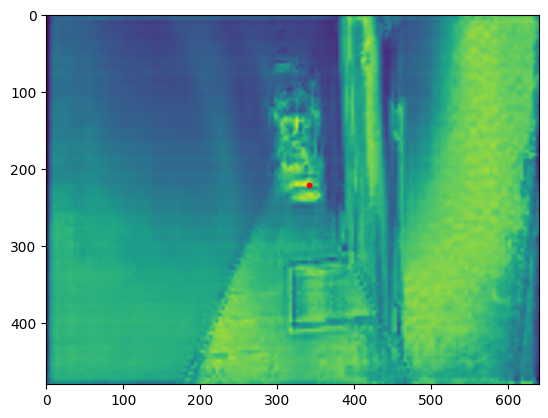

In [8]:
pred_depth = np.reshape(pred_depth, (480, 640))
print(pred_depth.max())
#Find index of max pred_depth
max_index = np.where(pred_depth == pred_depth.max())

plt.imshow(pred_depth)
plt.scatter(max_index[1], max_index[0], c='r', s=10)

In [9]:
def depth_to_pcd(depth_image, intrinsic, ):
    # Get dimensions of the depth image
    height, width = depth_image.shape

    # Generate a grid of (x, y) coordinates
    x, y = np.meshgrid(np.arange(width), np.arange(height))

    # Flatten the arrays
    x = x.flatten()
    y = y.flatten()
    depth = depth_image.flatten()

    # Calculate 3D coordinates
    fx, fy, cx, cy = intrinsic[0], intrinsic[5], intrinsic[2], intrinsic[6]
    z = depth

    x_3d = (x - cx) * z / fx
    y_3d = (y - cy) * z / fy

    # Create a point cloud
    points = np.vstack((x_3d, y_3d, z)).T
    return points

In [10]:
coord = depth_to_pcd(pred_depth, camera_info["K"])
coord = np.delete(coord, np.where(coord[:, 2] == 0), axis=0)
color = Image.open(IMG)
color = color.resize((640, 480), Image.BILINEAR)
color = np.array(color, dtype=np.float32)
color = color.reshape(-1, 3)/255.0
color = np.delete(color, np.where(coord[:, 2] == 0), axis=0)

In [11]:
print(coord.shape,color.shape)
print(coord.dtype,color.dtype)

(307200, 3) (307200, 3)
float64 float32


In [12]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(coord)
#pcd.colors = o3d.utility.Vector3dVector(color)
o3d.visualization.draw_geometries([pcd])